In [1]:
!pip install surprise
import pandas as pd
import json
import gzip
import numpy as np
import random
from surprise import accuracy
from surprise import Dataset
from surprise import Reader
from surprise import SVD,SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

from surprise.model_selection import GridSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt
from surprise.model_selection.validation import cross_validate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162992 sha256=14c71f05af0c894e341e9b6eb4d4bea55e60a8e4bfbdc51b228a8239d51221bb
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## loading datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
data_list = []

df = pd.read_csv('/content/drive/MyDrive/295A project/Data/marketBias/Data/electronics/df_electronics.csv')

In [4]:
df

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1292949,9478,1157628,1.0,2018-09-26,Female,Headphones,Etre Jeune,2017,NaN,0
1292950,9435,1157629,5.0,2018-09-26,Female,Computers & Accessories,NaN,2017,NaN,0
1292951,9305,1157630,3.0,2018-09-26,Female,Computers & Accessories,NaN,2016,NaN,0
1292952,9303,1157631,5.0,2018-09-29,Male,Headphones,NaN,2018,NaN,0


In [5]:
df['item_id'].nunique(),df['user_id'].nunique(),df['rating'].count()

(9560, 1157633, 1292954)

In [6]:
df['rating'].max(),df['rating'].min(),round(df['rating'].sum()/df['rating'].count(),2)

(5.0, 1.0, 4.05)

In [7]:
df['rating'].std(),df['rating'].var()

(1.3797324849527999, 1.9036617300340284)

In [8]:
from pandas._libs.missing import NA
sparsity = (df == 0 | df.isna()).any().astype(int).sum() / df.size
sparsity

2.3202681611256084e-07

In [9]:
df.isna().sum()

item_id             0
user_id             0
rating              0
timestamp           0
model_attr          0
category            0
brand          961834
year                0
user_attr     1118830
split               0
dtype: int64

In [10]:
df=df.drop(['brand','user_attr'],axis=1)

In [11]:
df.isna().sum()

item_id       0
user_id       0
rating        0
timestamp     0
model_attr    0
category      0
year          0
split         0
dtype: int64

In [12]:
df.dropna(inplace=True)


In [13]:
df.isna().sum()

item_id       0
user_id       0
rating        0
timestamp     0
model_attr    0
category      0
year          0
split         0
dtype: int64

<Axes: title={'center': 'quality'}, ylabel='Frequency'>

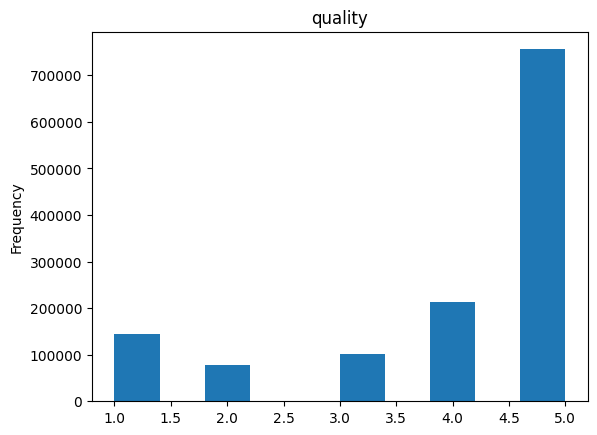

In [14]:
from matplotlib import pyplot as plt
df['rating'].plot(kind='hist', title='quality')
plt.gca()

## Building train and test sets

In [15]:
df.head()

,item_id,user_id,rating,timestamp,model_attr,category,year,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,1999,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,1999,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,1999,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,1999,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,1999,0


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from keras import regularizers
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [18]:
!pip install LibRecommender
from libreco.data import random_split, DatasetPure
from libreco.algorithms import NCF  # pure data,
from libreco.evaluation import evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.7 MB/s eta 0:00:00


Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
df["user"] = df["user_id"]
df["label"] = df["rating"]
#, "item", "label", "time"
df["item"] = df["item_id"]
df=df[["user","item","label"]]

In [20]:
train_data, eval_data, test_data = random_split(df, multi_ratios=[0.8, 0.1, 0.1])

In [21]:
train_data, data_info= DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)

In [22]:
ncf = NCF(
    task="rating",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=16,
    n_epochs=5,
    lr=1e-3,
    batch_size=2048,
    num_neg=1,
)

In [23]:
ncf.fit(
    train_data,
    neg_sampling=False, #for rating, this param is false else True
    verbose=2,
    eval_data=eval_data,
    metrics=["loss"],
)

# do final evaluation on test data
evaluate(
    model=ncf,
    data=test_data,
    neg_sampling=False,
    metrics=["loss"],
)

Training start time: 2024-05-03 09:26:54


/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.10/dist-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
train: 100%|██████████| 1011/1011 [03:41<00:00

Epoch 1 elapsed: 221.320s
	 train_loss: 2.6268


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 33.42it/s]


	 eval rmse: 1.2232


train: 100%|██████████| 1011/1011 [04:27<00:00,  3.78it/s]


Epoch 2 elapsed: 267.156s
	 train_loss: 0.8436


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 62.95it/s]


	 eval rmse: 1.3623


train: 100%|██████████| 1011/1011 [03:36<00:00,  4.66it/s]


Epoch 3 elapsed: 216.907s
	 train_loss: 0.4424


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 80.65it/s]


	 eval rmse: 1.2972


train: 100%|██████████| 1011/1011 [03:36<00:00,  4.67it/s]


Epoch 4 elapsed: 216.543s
	 train_loss: 0.1941


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 64.09it/s]


	 eval rmse: 1.3029


train: 100%|██████████| 1011/1011 [03:49<00:00,  4.40it/s]


Epoch 5 elapsed: 229.905s
	 train_loss: 0.1325


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 81.92it/s]


	 eval rmse: 1.2830


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 79.94it/s]


{'loss': 1.2885321}

In [24]:
evaluate(
    model=ncf,
    data=test_data,
    neg_sampling=False,
    metrics=["mae"],
)

eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 88.18it/s]


{'mae': 0.976093}

In [25]:
evaluate(
    model=ncf,
    data=test_data,
    neg_sampling=False,
    metrics=["rmse"],
)

eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 81.29it/s]


{'rmse': 1.2885321}

In [33]:
preds = []
actual = []
for i, row in df.iterrows():
    preds.append(round(ncf.predict(row["user"],row['item'])[0]))
    actual.append(round(row['label']))

Streaming output truncated to the last 5000 lines.
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 unknown interaction(s), position: [0]
Detect 1 

In [34]:
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(actual, preds, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.6785642757785586
Recall: 0.6473435902534341
F1 Score: 0.6541647903040714


In [26]:
import pickle
with open(r"/content/drive/MyDrive/295A project/Data/marketBias/Models/ncf.pickle", 'wb') as f:
    pickle.dump(ncf, f)

TypeError: cannot pickle 'Graph' object

In [ ]:
import joblib

# Save the model using joblib
joblib.dump(ncf, "/content/drive/MyDrive/295A project/Data/marketBias/Models/ncf_model.joblib")


TypeError: ignored